Importing the necessary libraries for the project.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install scikeras


In [7]:
import pandas as pd
import re #The regex library for preprocessing stage of the model.

# Libraries for tokenization.
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

#library for stop words removal.
nltk.download('stopwords')
from nltk.corpus import stopwords

#Libraries for stemmming
from nltk.stem import PorterStemmer

#library for building a vocabulary.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#library for splitting of dataset into training,validation and testing.
from sklearn.model_selection import train_test_split

#library for building a model.
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.regularizers import l1_l2

#library for data visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#library for BERT model.
!pip install datasets
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U

#library for T-Test Text Analysis
from scipy import stats

#library for optimisation
!pip install keras
!pip install tensorflow
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV









df = pd.read_csv("/content/drive/MyDrive/HS/hate speech.csv")

df.head(20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


Based on the first view of the dataset, I realise there are so many stop words, exclamation marks and other punctuations in the tweet column.As per my research,these must be removed prior to my model training. This will be done during the preprocessing stage of this project. For now, I wanted to probe further to find out the number of rows and columns in the dataset.

In [8]:
#Displaying the number of columns in the dataset.
print(df.columns)

#Displaying the number of records in the dataset
print(len(df))


Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')
24783


I discovered that the dataset has 7 columns and 24,783 records. For the purpose of this project,I will need only the hate_speech column and the tweet column in order to predict hate speech. Therefore, I decided to observe the values each column takes.
According to the dataset,0 means that the associated comment is not hate speech and 1 means that it is hate speech.

In [9]:
LABEL = df['hate_speech']
COMMENT = df['tweet']

print(LABEL)
print(COMMENT)

0        0
1        0
2        0
3        0
4        0
        ..
24778    0
24779    0
24780    0
24781    0
24782    0
Name: hate_speech, Length: 24783, dtype: int64
0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object


Prior to preprocessing,I looked into the normal convention in literature. Based on my research,there are certain objectives I need to achieve.


*   All texts need to be changed to lowercase since python is case sensitive.
*   All url,stop words,numbers need to be removed from the tweet columns. This is because they are not needed in the building of the model.

*   Tokenization needs to be done to break down sentences in the tweet column into smaller units i.e. words.

*   Stemming needs to be used to cut off the ends of words to obtain the base words.

Source:
https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9



In [10]:
#Before preprocessing,I would like to create a custom dataset which has the tweet column and the hate speech score.
new_df= pd.DataFrame()
new_df['TWEETS']=COMMENT
new_df['HATE_SPEECH_SCORE']= LABEL
new_df.head()

,TWEETS,HATE_SPEECH_SCORE
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


**CONVERT WORDS TO LOWERCASE**

The first step of my preprocessing is to convert all characters into lowercase since Python is case-sensitive,ython is case sensitive and this can impact my model.

In [11]:
new_df = new_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
new_df.head()

,TWEETS,HATE_SPEECH_SCORE
0,!!! rt @mayasolovely: as a woman you shouldn't...,0
1,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...,0
3,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...,0



**REMOVE ANY URL**

The next step is to remove any url in the dataset.

In [12]:
# Define a regex pattern to match URLs
url_pattern = re.compile(r'https?://\S+')

# Define a function to remove URLs from text
def remove_urls(text):
    return url_pattern.sub('', text)

# Apply the function to the 'text' column and create a new column 'clean_text'
new_df['TWEETS'] = new_df['TWEETS'].apply(remove_urls)

new_df.head(50)

,TWEETS,HATE_SPEECH_SCORE
0,!!! rt @mayasolovely: as a woman you shouldn't...,0
1,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...,0
3,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...,0
5,"!!!!!!!!!!!!!!!!!!""@t_madison_x: the shit just...",1
6,"!!!!!!""@__brighterdays: i can not just sit up ...",0
7,!!!!&#8220;@selfiequeenbri: cause i'm tired of...,0
8,""" &amp; you might not get ya bitch back &amp; ...",0
9,""" @rhythmixx_ :hobbies include: fighting maria...",1


**REMOVING NON-WORDS AND WHITESPACES**

This step is to remove any word that does not have any meaning as well as whitespaces for tokenization.

In [13]:
new_df = new_df.replace(to_replace=r'[^\w\s]', value='', regex=True)
new_df['TWEETS'] = new_df['TWEETS'].apply(lambda x: re.sub(r'\bRT\b|\brt\b', '', x, flags=re.IGNORECASE))

new_df.head(51)

,TWEETS,HATE_SPEECH_SCORE
0,mayasolovely as a woman you shouldnt complai...,0
1,mleew17 boy dats coldtyga dwn bad for cuffin...,0
2,urkindofbrand dawg 80sbaby4life you ever fu...,0
3,c_g_anderson viva_based she look like a tranny,0
4,shenikaroberts the shit you hear about me mi...,0
5,t_madison_x the shit just blows meclaim you so...,1
6,__brighterdays i can not just sit up and hate ...,0
7,8220selfiequeenbri cause im tired of you big b...,0
8,amp you might not get ya bitch back amp thats...,0
9,rhythmixx_ hobbies include fighting mariam\n\...,1


**REMOVAL OF NUMBERS & PUNCTUATIONS**

This step is to remove all numbers in the tweets since numbers have no relevant meaning as to whether a tweet is a hate speech or not



In [14]:
new_df = new_df.replace(to_replace=r'\d', value='', regex=True)
new_df.head(51)

,TWEETS,HATE_SPEECH_SCORE
0,mayasolovely as a woman you shouldnt complai...,0
1,mleew boy dats coldtyga dwn bad for cuffin d...,0
2,urkindofbrand dawg sbabylife you ever fuck ...,0
3,c_g_anderson viva_based she look like a tranny,0
4,shenikaroberts the shit you hear about me mi...,0
5,t_madison_x the shit just blows meclaim you so...,1
6,__brighterdays i can not just sit up and hate ...,0
7,selfiequeenbri cause im tired of you big bitch...,0
8,amp you might not get ya bitch back amp thats...,0
9,rhythmixx_ hobbies include fighting mariam\n\...,1


**TOKENIZATION & REMOVAL OF STOP WORDS**

The next stage is to tokenize each sentence in the TWEETS column.
This step is where sentences are broken down into smaller units i.e. words in order to feed the model with specific words.

In addition I removed stop words,which are part of speech that do not convey any meaningful meaning such as are,is etc.

In [15]:
new_df['TWEETS'] = new_df['TWEETS'].apply(word_tokenize)

In [16]:
stop_words = set(stopwords.words('english'))
new_df['TWEETS'] = new_df['TWEETS'].apply(lambda x: [word for word in x if word not in stop_words])
new_df.head(51)


,TWEETS,HATE_SPEECH_SCORE
0,"[mayasolovely, woman, shouldnt, complain, clea...",0
1,"[mleew, boy, dats, coldtyga, dwn, bad, cuffin,...",0
2,"[urkindofbrand, dawg, sbabylife, ever, fuck, b...",0
3,"[c_g_anderson, viva_based, look, like, tranny]",0
4,"[shenikaroberts, shit, hear, might, true, migh...",0
5,"[t_madison_x, shit, blows, meclaim, faithful, ...",1
6,"[__brighterdays, sit, hate, another, bitch, go...",0
7,"[selfiequeenbri, cause, im, tired, big, bitche...",0
8,"[amp, might, get, ya, bitch, back, amp, thats]",0
9,"[rhythmixx_, hobbies, include, fighting, maria...",1


**STEMMING**

The main idea of stemming is the cutting the ends of words in order to obtain the base words. for instance (automate,automatic,automation -> automat)
Upon further research ,I noticed there are different types of stemming approaches i.e. Porter stemming, Lovins stemming,Snowball stemming and Lancaster stemming.

For the purpose of this project,I decided to use porter stemming approach. This is because it is simple and fast in its execution,however it produces the best output.

 Snowball stemming is an advanced form of porter stemming but it is computationally expensive hence I don't have the computational resources to use it.
 For Lancaster stemming it is more agressive and less accurate,however the algorithm gets confused when dealing with small words and it is not efficient as well.


 In the case of Lovins stemming,it is fast and remove irregular plurals but it is time consuming and it frequently fails when executed.

Source:https://www.geeksforgeeks.org/introduction-to-stemming/


In [17]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Define a function to perform stemming on the 'TWEETS' column
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Define a function to perform stemming on the 'TWEETS' column
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Apply the function to the 'TWEETS' column.
new_df['TWEETS'] = new_df['TWEETS'].apply(stem_words)

new_df.head(51)

,TWEETS,HATE_SPEECH_SCORE
0,"[mayasolov, woman, shouldnt, complain, clean, ...",0
1,"[mleew, boy, dat, coldtyga, dwn, bad, cuffin, ...",0
2,"[urkindofbrand, dawg, sbabylif, ever, fuck, bi...",0
3,"[c_g_anderson, viva_bas, look, like, tranni]",0
4,"[shenikarobert, shit, hear, might, true, might...",0
5,"[t_madison_x, shit, blow, meclaim, faith, some...",1
6,"[__brighterday, sit, hate, anoth, bitch, got, ...",0
7,"[selfiequeenbri, caus, im, tire, big, bitch, c...",0
8,"[amp, might, get, ya, bitch, back, amp, that]",0
9,"[rhythmixx_, hobbi, includ, fight, mariam, bitch]",1


**WORD VOCABULARY**

This step is when we create a bag of words such that the most popular words are highlighted.

In [18]:
max_words = 500

# Step 2: Create a Tokenizer instance with num_words set to 50,000
max_words = 500
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(new_df.TWEETS)

sequences = tokenizer.texts_to_sequences(new_df.TWEETS)
sequences_matrix = pad_sequences(sequences, max_words)

sequences_matrix.shape


(24783, 500)

**DATA VISUALISATION**

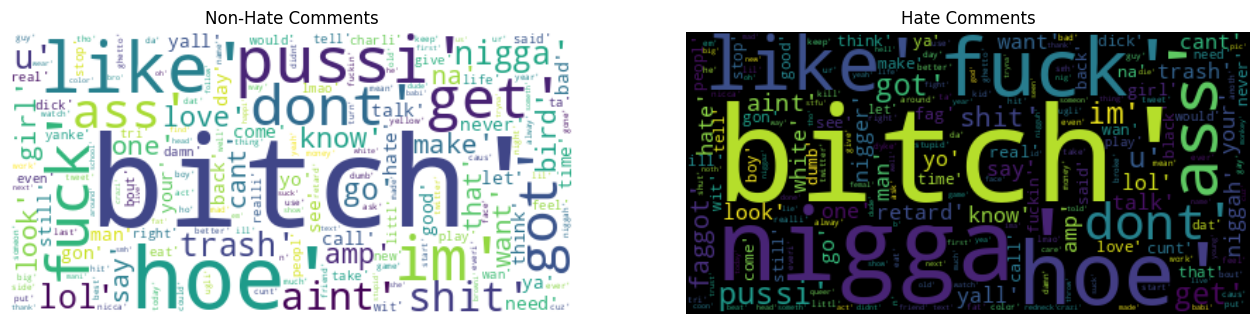

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

text_pos = " ".join(map(str, new_df.loc[new_df['HATE_SPEECH_SCORE'] == 0, 'TWEETS']))
text_neg = " ".join(map(str, new_df.loc[new_df['HATE_SPEECH_SCORE'] == 1, 'TWEETS']))

train_cloud_pos = WordCloud(collocations=False, background_color='white').generate(text_pos)
train_cloud_neg = WordCloud(collocations=False, background_color='black').generate(text_neg)

axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')

axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

Upon my research I realised that hate speech detection datasets are subjective however a tweet/comment is classified a hate speech or not based on the creator of the dataset. This explains why similar words can be found boldened in both the Non-hate comment bag and the hate comment bag.

**T-TEST FOR TEXT LENGTHS**

This test helps determine if there's a significant difference in the mean text lengths between hate speech and non-hate speech comments.

In [20]:
# Join the tokenized words back into strings for each tweet
new_df['TWEETS'] = new_df['TWEETS'].apply(lambda x: ' '.join(x))

# Calculate text lengths for hate speech and non-hate speech comments
new_df['text_length'] = new_df['TWEETS'].apply(lambda x: len(x.split()))

# Extract text lengths for hate speech and non-hate speech
hate_speech_lengths = new_df[new_df['HATE_SPEECH_SCORE'] == 1]['text_length']
non_hate_speech_lengths = new_df[new_df['HATE_SPEECH_SCORE'] == 0]['text_length']

# Perform t-test for text lengths
t_stat, p_value = stats.ttest_ind(hate_speech_lengths, non_hate_speech_lengths)
print(f"T-Test for Text Lengths - T-statistic: {t_stat}, p-value: {p_value}")



T-Test for Text Lengths - T-statistic: 6.088697201853848, p-value: 1.1562045410191131e-09


The T-test performed on the text lengths of hate speech and non-hate speech comments yielded a significant result. The obtained T-statistic value of approximately 6.09 and the very small p-value, around \(1.16 \times 10^{-9}\), indicate a substantial difference in the average text lengths between these two categories of comments.
In essence, this statistical analysis confirms that there is a significant discrepancy in text lengths between hate speech and non-hate speech comments within your dataset.

**SPLITTING DATASET INTO TRAINING,VALIDATION AND TESTING**



In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(sequences_matrix, new_df.HATE_SPEECH_SCORE, test_size= 0.2, random_state=42)

**BUILDING A MODEL USING LSTM**

This code defines a function `create_model` that creates a text classification neural network using LSTM layers. It allows for customization of architecture and regularization, with parameters for input, embedding, LSTM, dense layers, output layer, and model compilation. This customizable model allows for control over architectural elements and regularization techniques.



In [22]:
def create_model(lstm_units=64, dense_units=256, l1_reg=0.01, l2_reg=0.01, learning_rate=0.001):
    inputs = Input(name='inputs', shape=[max_words])
    layer = Embedding(2000, 100, input_length=max_words)(inputs)
    layer = LSTM(lstm_units)(layer)
    layer = Dense(dense_units, name='FC1', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model





In [23]:
    # Create model
    model = create_model()

    history = model.fit(Xtrain, ytrain, validation_split=0.33, epochs = 20, batch_size = 32)

Epoch 1/20
416/416 [==============================] - 52s 84ms/step - loss: 1.9826 - accuracy: 0.7911 - val_loss: 0.5423 - val_accuracy: 0.8083
Epoch 2/20
416/416 [==============================] - 10s 25ms/step - loss: 0.5362 - accuracy: 0.7810 - val_loss: 0.5139 - val_accuracy: 0.7857
Epoch 3/20
416/416 [==============================] - 9s 22ms/step - loss: 0.4979 - accuracy: 0.7774 - val_loss: 0.4896 - val_accuracy: 0.7741
Epoch 4/20
416/416 [==============================] - 10s 25ms/step - loss: 0.4656 - accuracy: 0.7737 - val_loss: 0.4792 - val_accuracy: 0.7790
Epoch 5/20
416/416 [==============================] - 10s 25ms/step - loss: 0.4378 - accuracy: 0.7810 - val_loss: 0.5296 - val_accuracy: 0.7217
Epoch 6/20
416/416 [==============================] - 9s 22ms/step - loss: 0.3875 - accuracy: 0.7869 - val_loss: 0.4902 - val_accuracy: 0.7818
Epoch 7/20
416/416 [==============================] - 10s 24ms/step - loss: 0.2379 - accuracy: 0.7882 - val_loss: 0.3794 - val_accuracy: 0

In [24]:
evaluation = model.evaluate(Xtest, ytest)

155/155 [==============================] - 1s 9ms/step - loss: -2.1687 - accuracy: 0.7741


With an epochs of 20 and a batch size of 32,the model accuracy is 77.41%.

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The code defines a model creation function with configurable LSTM and dense layers, then uses GridSearchCV to explore combinations of hyperparameters for the LSTM-based model systematically. It searches for the best hyperparameter values by evaluating the model's performance using cross-validation and displays the best parameter set and its corresponding score achieved during the search.

**EVALUATION & OPTIMISATION FOR LSTM**

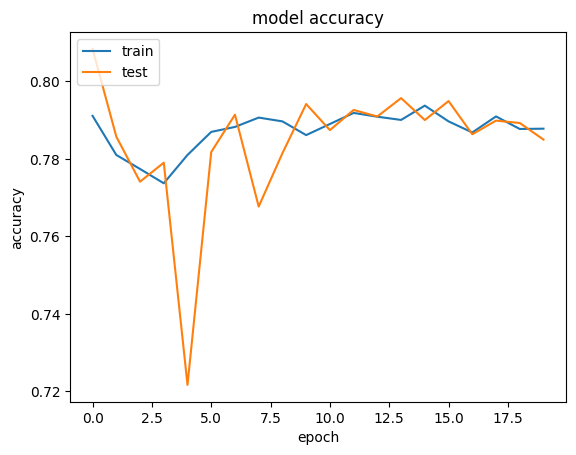

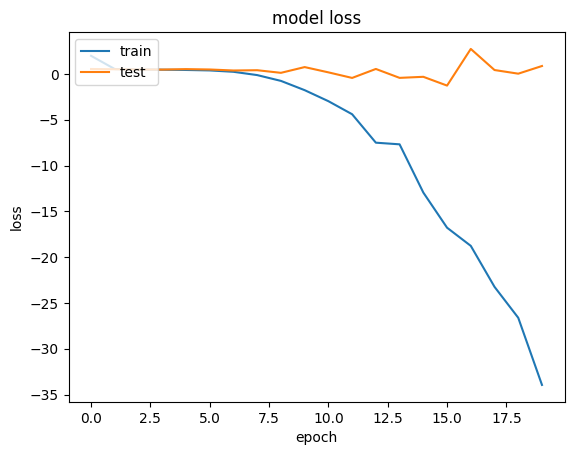

In [79]:
# summarize history for accuracy
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


This code is to optimize the LSTM model's performance by systematically exploring different hyperparameter combinations and identifying the most effective configuration for the given dataset

In [34]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the model creation function
def create_model(lstm_units=64, dense_units=128, learning_rate=0.001, dropout_rate=0.5):
    inputs = Input(name='inputs', shape=(10, 50))  # Adjusts the shape to match input data shape
    layer = LSTM(lstm_units)(inputs)  # Use LSTM layer directly on the input data
    layer = Dense(dense_units, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

# Reshape input data to match the expected shape
Xtrain_reshaped = np.reshape(Xtrain, (-1, 10, 50))


# Define the parameter grid
param_grid = {
    'lstm_units': [32, 64],
    'dense_units': [128, 256],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.3, 0.5],
}

# Creates the KerasClassifier using the correct function name
lstm_model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32,lstm_units=64, dense_units=128, learning_rate=0.001, dropout_rate=0.5, verbose=1)

# Uses the param_grid in GridSearchCV
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3, error_score='raise')

# This code fits the GridSearchCV to the data
grid_result = grid_search.fit(Xtrain_reshaped, ytrain)

# This code displays the best parameters and best score
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 6ms/step - loss: 0.6053 - accuracy: 0.7825
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5899 - accuracy: 0.7980
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5910 - accuracy: 0.7980
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5855 - accuracy: 0.7979
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5826 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5815 - accuracy: 0.7970
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5777 - accuracy: 0.7975
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5763 - accuracy: 0.7964
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5781 - accuracy: 0.7910
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5747 - accuracy: 0.7924

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6017 - accuracy: 0.7924
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5911 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5881 - accuracy: 0.7976
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5875 - accuracy: 0.7978
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5850 - accuracy: 0.7969
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5848 - accuracy: 0.7960
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5816 - accuracy: 0.7978
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5824 - accuracy: 0.7975
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5778 - accuracy: 0.7960
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5756 - accuracy: 0.7953

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 6ms/step - loss: 0.6012 - accuracy: 0.7939
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5918 - accuracy: 0.7972
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5869 - accuracy: 0.7973
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5827 - accuracy: 0.7974
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5804 - accuracy: 0.7965
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5792 - accuracy: 0.7977
Epoch 7/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5790 - accuracy: 0.7965
Epoch 8/20
414/414 [==============================] - 4s 10ms/step - loss: 0.5772 - accuracy: 0.7969
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5773 - accuracy: 0.7960
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5766 - accuracy: 0.795

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6031 - accuracy: 0.7955
Epoch 2/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5926 - accuracy: 0.7966
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5879 - accuracy: 0.7970
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5849 - accuracy: 0.7969
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5819 - accuracy: 0.7966
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.7945
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5794 - accuracy: 0.7956
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5762 - accuracy: 0.7934
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5755 - accuracy: 0.7910
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5742 - accuracy: 0.7898

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6030 - accuracy: 0.7887
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5885 - accuracy: 0.7951
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5881 - accuracy: 0.7961
Epoch 4/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5870 - accuracy: 0.7955
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5836 - accuracy: 0.7957
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5821 - accuracy: 0.7968
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7935
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5773 - accuracy: 0.7926
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5751 - accuracy: 0.7918
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5762 - accuracy: 0.7876

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6030 - accuracy: 0.7923
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5931 - accuracy: 0.7976
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5855 - accuracy: 0.7969
Epoch 4/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5838 - accuracy: 0.7950
Epoch 5/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5811 - accuracy: 0.7952
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.7938
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5782 - accuracy: 0.7888
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5746 - accuracy: 0.7935
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5753 - accuracy: 0.7932
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5734 - accuracy: 0.7900

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6050 - accuracy: 0.7936
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5975 - accuracy: 0.7963
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5948 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5912 - accuracy: 0.7977
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5891 - accuracy: 0.7950
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5906 - accuracy: 0.7972
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5911 - accuracy: 0.7964
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5906 - accuracy: 0.7978
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7973

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6083 - accuracy: 0.7931
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5975 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5950 - accuracy: 0.7980
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5934 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5932 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5943 - accuracy: 0.7979
Epoch 8/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5924 - accuracy: 0.7981
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5926 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6075 - accuracy: 0.7954
Epoch 2/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5940 - accuracy: 0.7980
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5945 - accuracy: 0.7978
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5909 - accuracy: 0.7980
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5908 - accuracy: 0.7975
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7980
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5920 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5911 - accuracy: 0.7978
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5909 - accuracy: 0.7969

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6056 - accuracy: 0.7904
Epoch 2/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5968 - accuracy: 0.7981
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5909 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5907 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5902 - accuracy: 0.7980
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6090 - accuracy: 0.7918
Epoch 2/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5966 - accuracy: 0.7981
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5945 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5946 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7974
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7965
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5932 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5931 - accuracy: 0.7982

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6097 - accuracy: 0.7898
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.7980
Epoch 3/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5931 - accuracy: 0.7979
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5915 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5910 - accuracy: 0.7968
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5910 - accuracy: 0.7977
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5915 - accuracy: 0.7978
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7979
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5907 - accuracy: 0.7973

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6068 - accuracy: 0.7825
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7977
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5936 - accuracy: 0.7978
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5873 - accuracy: 0.7976
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5867 - accuracy: 0.7978
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5842 - accuracy: 0.7967
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5845 - accuracy: 0.7953
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5810 - accuracy: 0.7949
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5808 - accuracy: 0.7942
Epoch 10/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5783 - accuracy: 0.7913

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6034 - accuracy: 0.7944
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5911 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5879 - accuracy: 0.7978
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5869 - accuracy: 0.7972
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5868 - accuracy: 0.7973
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5842 - accuracy: 0.7979
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5823 - accuracy: 0.7976
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5813 - accuracy: 0.7962
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5800 - accuracy: 0.7961
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5792 - accuracy: 0.7947

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6082 - accuracy: 0.7867
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7970
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5908 - accuracy: 0.7968
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5900 - accuracy: 0.7975
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5865 - accuracy: 0.7975
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5829 - accuracy: 0.7975
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5855 - accuracy: 0.7966
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5832 - accuracy: 0.7974
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5805 - accuracy: 0.7971
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5773 - accuracy: 0.7956

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6089 - accuracy: 0.7801
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7965
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5879 - accuracy: 0.7967
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5844 - accuracy: 0.7953
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5829 - accuracy: 0.7953
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5794 - accuracy: 0.7947
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5832 - accuracy: 0.7954
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5792 - accuracy: 0.7943
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5780 - accuracy: 0.7917
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5818 - accuracy: 0.7884

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6102 - accuracy: 0.7815
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5964 - accuracy: 0.7952
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5932 - accuracy: 0.7974
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5877 - accuracy: 0.7975
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5881 - accuracy: 0.7968
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5880 - accuracy: 0.7968
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5830 - accuracy: 0.7950
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5819 - accuracy: 0.7958
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5793 - accuracy: 0.7929
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5780 - accuracy: 0.7939

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6089 - accuracy: 0.7817
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7967
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5902 - accuracy: 0.7960
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5859 - accuracy: 0.7966
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5835 - accuracy: 0.7969
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5826 - accuracy: 0.7959
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5821 - accuracy: 0.7953
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5831 - accuracy: 0.7957
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5811 - accuracy: 0.7946
Epoch 10/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5776 - accuracy: 0.7923

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6088 - accuracy: 0.7916
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.7972
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5956 - accuracy: 0.7970
Epoch 4/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5930 - accuracy: 0.7979
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5907 - accuracy: 0.7977
Epoch 10/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5910 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6095 - accuracy: 0.7920
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5976 - accuracy: 0.7964
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7972
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7969
Epoch 5/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5944 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5930 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7978
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5945 - accuracy: 0.7962

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6083 - accuracy: 0.7923
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5967 - accuracy: 0.7980
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5934 - accuracy: 0.7980
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5931 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5954 - accuracy: 0.7976
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5956 - accuracy: 0.7969
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7979
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7972
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5915 - accuracy: 0.7978
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6120 - accuracy: 0.7912
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.7975
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5920 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5926 - accuracy: 0.7978
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5910 - accuracy: 0.7980
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5918 - accuracy: 0.7961
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5924 - accuracy: 0.7975

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6107 - accuracy: 0.7915
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5982 - accuracy: 0.7981
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5958 - accuracy: 0.7979
Epoch 4/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5929 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5952 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5941 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5959 - accuracy: 0.7966
Epoch 8/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5938 - accuracy: 0.7974
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7982
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7972

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 7ms/step - loss: 0.6114 - accuracy: 0.7894
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.6046 - accuracy: 0.7962
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5946 - accuracy: 0.7974
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7977
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7980
Epoch 7/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5928 - accuracy: 0.7980
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5922 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5920 - accuracy: 0.7978
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5933 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 6ms/step - loss: 0.6000 - accuracy: 0.7941
Epoch 2/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5879 - accuracy: 0.7981
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5869 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5837 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5822 - accuracy: 0.7977
Epoch 6/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5793 - accuracy: 0.7963
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5779 - accuracy: 0.7969
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5761 - accuracy: 0.7938
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5749 - accuracy: 0.7894
Epoch 10/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5741 - accuracy: 0.7889

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6022 - accuracy: 0.7968
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5884 - accuracy: 0.7982
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5843 - accuracy: 0.7975
Epoch 5/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5845 - accuracy: 0.7972
Epoch 6/20
414/414 [==============================] - 3s 8ms/step - loss: 0.5811 - accuracy: 0.7980
Epoch 7/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5805 - accuracy: 0.7961
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7944
Epoch 9/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5774 - accuracy: 0.7899
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5726 - accuracy: 0.7922

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6026 - accuracy: 0.7960
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5901 - accuracy: 0.7958
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5872 - accuracy: 0.7967
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5852 - accuracy: 0.7962
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5847 - accuracy: 0.7969
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5812 - accuracy: 0.7970
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5796 - accuracy: 0.7960
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5772 - accuracy: 0.7963
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5758 - accuracy: 0.7929
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5769 - accuracy: 0.7910

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 7ms/step - loss: 0.6010 - accuracy: 0.7972
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5920 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5861 - accuracy: 0.7978
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5857 - accuracy: 0.7968
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5801 - accuracy: 0.7956
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5783 - accuracy: 0.7928
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5770 - accuracy: 0.7916
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5739 - accuracy: 0.7908
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5725 - accuracy: 0.7898
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5706 - accuracy: 0.7880

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6031 - accuracy: 0.7900
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5929 - accuracy: 0.7962
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5870 - accuracy: 0.7965
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5830 - accuracy: 0.7957
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5807 - accuracy: 0.7946
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5790 - accuracy: 0.7935
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5777 - accuracy: 0.7902
Epoch 8/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5735 - accuracy: 0.7922
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5717 - accuracy: 0.7823
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5714 - accuracy: 0.7871

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6005 - accuracy: 0.7916
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5882 - accuracy: 0.7972
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5847 - accuracy: 0.7972
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5815 - accuracy: 0.7959
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.7938
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5805 - accuracy: 0.7944
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5761 - accuracy: 0.7899
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5735 - accuracy: 0.7929
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5728 - accuracy: 0.7901
Epoch 10/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5698 - accuracy: 0.7879

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6055 - accuracy: 0.7931
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.6007 - accuracy: 0.7950
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5933 - accuracy: 0.7972
Epoch 4/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5938 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5924 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5904 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5907 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7979
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5903 - accuracy: 0.7968
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5915 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6067 - accuracy: 0.7958
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5970 - accuracy: 0.7969
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5957 - accuracy: 0.7974
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5950 - accuracy: 0.7981
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5961 - accuracy: 0.7959
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5909 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5932 - accuracy: 0.7980
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7978
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7980
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6108 - accuracy: 0.7917
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5977 - accuracy: 0.7962
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5955 - accuracy: 0.7976
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5966 - accuracy: 0.7969
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7975
Epoch 6/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5911 - accuracy: 0.7976
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5935 - accuracy: 0.7969
Epoch 8/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5930 - accuracy: 0.7963
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5911 - accuracy: 0.7973
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7972

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 7ms/step - loss: 0.6110 - accuracy: 0.7910
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5990 - accuracy: 0.7955
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5936 - accuracy: 0.7980
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7979
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5905 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5941 - accuracy: 0.7965
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5933 - accuracy: 0.7972
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5908 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5897 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 6ms/step - loss: 0.6093 - accuracy: 0.7889
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.7969
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5946 - accuracy: 0.7979
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7982
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5946 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5938 - accuracy: 0.7978
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5935 - accuracy: 0.7970
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.7978
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 7ms/step - loss: 0.6111 - accuracy: 0.7904
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5973 - accuracy: 0.7980
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5936 - accuracy: 0.7978
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7961
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5924 - accuracy: 0.7980
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.7980
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7969
Epoch 8/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5910 - accuracy: 0.7976
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5914 - accuracy: 0.7979
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5920 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6046 - accuracy: 0.7882
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5921 - accuracy: 0.7979
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5893 - accuracy: 0.7982
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5869 - accuracy: 0.7979
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5848 - accuracy: 0.7970
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5820 - accuracy: 0.7971
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5832 - accuracy: 0.7952
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5778 - accuracy: 0.7934
Epoch 9/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5760 - accuracy: 0.7916
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5771 - accuracy: 0.7885

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6044 - accuracy: 0.7895
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5899 - accuracy: 0.7975
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5847 - accuracy: 0.7976
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5853 - accuracy: 0.7958
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5842 - accuracy: 0.7965
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5801 - accuracy: 0.7936
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5804 - accuracy: 0.7941
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5795 - accuracy: 0.7926
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5761 - accuracy: 0.7917
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5725 - accuracy: 0.7896

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6034 - accuracy: 0.7899
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5947 - accuracy: 0.7978
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5891 - accuracy: 0.7975
Epoch 4/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5854 - accuracy: 0.7977
Epoch 5/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5850 - accuracy: 0.7966
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5822 - accuracy: 0.7953
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5828 - accuracy: 0.7960
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5833 - accuracy: 0.7954
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5782 - accuracy: 0.7947
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5776 - accuracy: 0.7943

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6047 - accuracy: 0.7922
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7966
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5870 - accuracy: 0.7951
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5857 - accuracy: 0.7944
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5829 - accuracy: 0.7914
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5809 - accuracy: 0.7924
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5790 - accuracy: 0.7871
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5790 - accuracy: 0.7900
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5735 - accuracy: 0.7899
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5736 - accuracy: 0.7893

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6003 - accuracy: 0.7940
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5897 - accuracy: 0.7941
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5857 - accuracy: 0.7974
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5862 - accuracy: 0.7971
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5856 - accuracy: 0.7962
Epoch 6/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5803 - accuracy: 0.7953
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5820 - accuracy: 0.7953
Epoch 8/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5803 - accuracy: 0.7937
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5810 - accuracy: 0.7910
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5763 - accuracy: 0.7925

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6004 - accuracy: 0.7912
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5910 - accuracy: 0.7968
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5907 - accuracy: 0.7946
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5859 - accuracy: 0.7964
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5812 - accuracy: 0.7956
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5801 - accuracy: 0.7930
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5805 - accuracy: 0.7960
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.7933
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5770 - accuracy: 0.7944
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5742 - accuracy: 0.7921

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 6s 6ms/step - loss: 0.6123 - accuracy: 0.7935
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.6002 - accuracy: 0.7975
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.7972
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5960 - accuracy: 0.7973
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7981
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5926 - accuracy: 0.7976
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5927 - accuracy: 0.7981
Epoch 8/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5914 - accuracy: 0.7964
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5900 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 6ms/step - loss: 0.6090 - accuracy: 0.7925
Epoch 2/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5991 - accuracy: 0.7959
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5974 - accuracy: 0.7974
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5947 - accuracy: 0.7978
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.7977
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7978
Epoch 7/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5933 - accuracy: 0.7973
Epoch 8/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5937 - accuracy: 0.7978
Epoch 9/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5921 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6125 - accuracy: 0.7866
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.6033 - accuracy: 0.7933
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5934 - accuracy: 0.7979
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5934 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7980
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7978
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7958
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7974
Epoch 9/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5930 - accuracy: 0.7979
Epoch 10/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5926 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6172 - accuracy: 0.7829
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.6006 - accuracy: 0.7959
Epoch 3/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5940 - accuracy: 0.7981
Epoch 4/20
414/414 [==============================] - 3s 7ms/step - loss: 0.5960 - accuracy: 0.7964
Epoch 5/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5956 - accuracy: 0.7972
Epoch 6/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5965 - accuracy: 0.7981
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5943 - accuracy: 0.7976
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7979
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7981
Epoch 10/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5925 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 4s 5ms/step - loss: 0.6163 - accuracy: 0.7824
Epoch 2/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5988 - accuracy: 0.7971
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.7979
Epoch 4/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5983 - accuracy: 0.7961
Epoch 5/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5953 - accuracy: 0.7978
Epoch 6/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5952 - accuracy: 0.7971
Epoch 7/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7966
Epoch 8/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5950 - accuracy: 0.7981
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7978
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5933 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
414/414 [==============================] - 5s 5ms/step - loss: 0.6165 - accuracy: 0.7803
Epoch 2/20
414/414 [==============================] - 2s 5ms/step - loss: 0.6058 - accuracy: 0.7937
Epoch 3/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5970 - accuracy: 0.7962
Epoch 4/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7980
Epoch 5/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.7971
Epoch 6/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5951 - accuracy: 0.7972
Epoch 7/20
414/414 [==============================] - 3s 6ms/step - loss: 0.5941 - accuracy: 0.7980
Epoch 8/20
414/414 [==============================] - 2s 6ms/step - loss: 0.5925 - accuracy: 0.7980
Epoch 9/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5915 - accuracy: 0.7980
Epoch 10/20
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
620/620 [==============================] - 7s 7ms/step - loss: 0.5971 - accuracy: 0.7962
Epoch 2/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5885 - accuracy: 0.7980
Epoch 3/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5869 - accuracy: 0.7973
Epoch 4/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5838 - accuracy: 0.7981
Epoch 5/20
620/620 [==============================] - 3s 6ms/step - loss: 0.5825 - accuracy: 0.7976
Epoch 6/20
620/620 [==============================] - 4s 6ms/step - loss: 0.5807 - accuracy: 0.7955
Epoch 7/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5799 - accuracy: 0.7940
Epoch 8/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5785 - accuracy: 0.7934
Epoch 9/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5785 - accuracy: 0.7910
Epoch 10/20
620/620 [==============================] - 3s 6ms/step - loss: 0.5752 - accuracy: 0.7914

After conducting a grid search and found the best parameters,the model achieved an accuracy of 79.81% on its validation set indicating its performance of a particular combination of parameters.

**Training a model using Grid Search**

In [62]:

# Assuming grid_result is your GridSearchCV object with the best_params_ attribute
best_params = grid_result.best_params_

# Creates the best model using the best parameters
best_model = create_model(lstm_units=best_params['lstm_units'],
                          dense_units=best_params['dense_units'],
                          learning_rate=best_params['learning_rate'],
                          dropout_rate=best_params['dropout_rate'])

# Reshapes the test data
Xtest_reshaped = np.reshape(Xtest, (-1, 10, 50))  # Assuming Xtest has the same shape as Xtrain

# Trains the best model on the whole training set
best_model.fit(Xtrain_reshaped, ytrain, epochs=20, batch_size=32, verbose=1)

# Make predictions on the test data
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy of the predicted labels against ytest
accuracy = accuracy_score(ytest, predicted_labels)
print("Accuracy:", accuracy)



Epoch 1/20
620/620 [==============================] - 9s 8ms/step - loss: 0.5991 - accuracy: 0.7940
Epoch 2/20
620/620 [==============================] - 5s 9ms/step - loss: 0.5894 - accuracy: 0.7978
Epoch 3/20
620/620 [==============================] - 5s 8ms/step - loss: 0.5883 - accuracy: 0.7977
Epoch 4/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5858 - accuracy: 0.7979
Epoch 5/20
620/620 [==============================] - 4s 6ms/step - loss: 0.5843 - accuracy: 0.7949
Epoch 6/20
620/620 [==============================] - 4s 6ms/step - loss: 0.5827 - accuracy: 0.7973
Epoch 7/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5817 - accuracy: 0.7934
Epoch 8/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5785 - accuracy: 0.7934
Epoch 9/20
620/620 [==============================] - 3s 5ms/step - loss: 0.5782 - accuracy: 0.7934
Epoch 10/20
620/620 [==============================] - 4s 6ms/step - loss: 0.5765 - accuracy: 0.7906

Accuracy score after passing the LSTM model through grid search is 80%.

**Mean Absolute Error**

In [63]:
from sklearn.metrics import mean_absolute_error

# Assuming ytest is your ground truth labels for the test data
mae = mean_absolute_error(ytest, predicted_labels)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.27435949162800083



A mean absolute error of approximately 0.2744 suggests the average absolute difference between predicted values and actual values

**Root Mean Squared Error**

In [64]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = mean_squared_error(ytest, predicted_labels, squared=False)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 0.6713239247807681


The RMSE of 0.6713239247807681 indicates that the model's predictions are closer to the actual values.

**Building a GRU model**

After using LSTM model to train,I decided to use the GRU model to train to see whether I will get a better accuracy score than that of LSTM.

In [73]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the GRU model creation function
def create_gru_model(units=64, dense_units=128, learning_rate=0.001, dropout_rate=0.5):
    inputs = Input(name='inputs', shape=(10, 50))  # Adjust the shape to match input data shape
    layer = GRU(units=units)(inputs)  # Use GRU layer directly on the input data
    layer = Dense(dense_units, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

# Reshape your input data to match the expected shape
# Assuming Xtrain is your input data with shape (None, 500)
Xtrain_reshaped = np.reshape(Xtrain, (-1, 10, 50))

# Define the parameter grid
param_grid = {
    'units': [32, 64],
    'dense_units': [128, 256],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.3, 0.5],
}

# Create the KerasClassifier using the correct function name
gru_model = KerasClassifier(build_fn=create_gru_model, epochs=15, batch_size=32, units=64, dense_units=128, learning_rate=0.001, dropout_rate=0.5, verbose=1)

# Use the param_grid in GridSearchCV
grid_search = GridSearchCV(estimator=gru_model, param_grid=param_grid, cv=3, error_score='raise')

# Fit the GridSearchCV to your data
grid_result = grid_search.fit(Xtrain_reshaped, ytrain)

# Display the best parameters and best score
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 9s 7ms/step - loss: 0.6066 - accuracy: 0.7944
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5940 - accuracy: 0.7968
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7970
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5869 - accuracy: 0.7965
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5890 - accuracy: 0.7944
Epoch 6/15
414/414 [==============================] - 5s 11ms/step - loss: 0.5851 - accuracy: 0.7966
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5800 - accuracy: 0.7966
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5812 - accuracy: 0.7949
Epoch 9/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5798 - accuracy: 0.7922
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5775 - accuracy: 0.788

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 6ms/step - loss: 0.6106 - accuracy: 0.7894
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5911 - accuracy: 0.7950
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5891 - accuracy: 0.7959
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5824 - accuracy: 0.7947
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5843 - accuracy: 0.7947
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5804 - accuracy: 0.7937
Epoch 7/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5812 - accuracy: 0.7921
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5775 - accuracy: 0.7903
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5760 - accuracy: 0.7892
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5754 - accuracy: 0.7857

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 8ms/step - loss: 0.6104 - accuracy: 0.7889
Epoch 2/15
414/414 [==============================] - 5s 11ms/step - loss: 0.5969 - accuracy: 0.7965
Epoch 3/15
414/414 [==============================] - 4s 10ms/step - loss: 0.5888 - accuracy: 0.7969
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5876 - accuracy: 0.7970
Epoch 5/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5833 - accuracy: 0.7978
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5838 - accuracy: 0.7962
Epoch 7/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5828 - accuracy: 0.7964
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5804 - accuracy: 0.7947
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5808 - accuracy: 0.7973
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5786 - accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 8s 12ms/step - loss: 0.6134 - accuracy: 0.7828
Epoch 2/15
414/414 [==============================] - 4s 11ms/step - loss: 0.5953 - accuracy: 0.7956
Epoch 3/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5873 - accuracy: 0.7951
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5831 - accuracy: 0.7915
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5818 - accuracy: 0.7928
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5782 - accuracy: 0.7904
Epoch 7/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5777 - accuracy: 0.7897
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5770 - accuracy: 0.7910
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.7910
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5740 - accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 8s 8ms/step - loss: 0.6143 - accuracy: 0.7791
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5943 - accuracy: 0.7941
Epoch 3/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5881 - accuracy: 0.7942
Epoch 4/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5835 - accuracy: 0.7958
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5826 - accuracy: 0.7951
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5783 - accuracy: 0.7906
Epoch 7/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5790 - accuracy: 0.7883
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5768 - accuracy: 0.7891
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5756 - accuracy: 0.7885
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5751 - accuracy: 0.7865

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6134 - accuracy: 0.7776
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5961 - accuracy: 0.7932
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5880 - accuracy: 0.7922
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5877 - accuracy: 0.7941
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5846 - accuracy: 0.7946
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5817 - accuracy: 0.7951
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5792 - accuracy: 0.7927
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5781 - accuracy: 0.7925
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5769 - accuracy: 0.7885
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5747 - accuracy: 0.7886

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 10s 7ms/step - loss: 0.6081 - accuracy: 0.7920
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5962 - accuracy: 0.7981
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5917 - accuracy: 0.7970
Epoch 5/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5924 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5913 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5914 - accuracy: 0.798

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6092 - accuracy: 0.7857
Epoch 2/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5969 - accuracy: 0.7978
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5938 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5932 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7979
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5954 - accuracy: 0.7956
Epoch 8/15
414/414 [==============================] - 5s 12ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 5s 11ms/step - loss: 0.5939 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5937 - accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6089 - accuracy: 0.7869
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5975 - accuracy: 0.7980
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7980
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5922 - accuracy: 0.7980
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5925 - accuracy: 0.7977
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5930 - accuracy: 0.7980
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7979
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5924 - accuracy: 0.7980
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7980
Epoch 10/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5920 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6101 - accuracy: 0.7886
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5945 - accuracy: 0.7972
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5911 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5913 - accuracy: 0.7980
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5897 - accuracy: 0.7983
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5895 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5906 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 6ms/step - loss: 0.6108 - accuracy: 0.7909
Epoch 2/15
414/414 [==============================] - 3s 6ms/step - loss: 0.6031 - accuracy: 0.7938
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5936 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7977
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7980
Epoch 8/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5936 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5934 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5953 - accuracy: 0.7972

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6113 - accuracy: 0.7864
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5975 - accuracy: 0.7980
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5977 - accuracy: 0.7964
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5951 - accuracy: 0.7956
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7980
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5938 - accuracy: 0.7980
Epoch 7/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5935 - accuracy: 0.7973
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7980
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7980
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5954 - accuracy: 0.7963

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6163 - accuracy: 0.7888
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6017 - accuracy: 0.7954
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5966 - accuracy: 0.7977
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5901 - accuracy: 0.7976
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5900 - accuracy: 0.7975
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5906 - accuracy: 0.7972
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5874 - accuracy: 0.7977
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5875 - accuracy: 0.7974
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5861 - accuracy: 0.7976
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5857 - accuracy: 0.7972

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6182 - accuracy: 0.7793
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6001 - accuracy: 0.7961
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5931 - accuracy: 0.7976
Epoch 4/15
414/414 [==============================] - 4s 10ms/step - loss: 0.5895 - accuracy: 0.7975
Epoch 5/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5877 - accuracy: 0.7968
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5862 - accuracy: 0.7971
Epoch 7/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5842 - accuracy: 0.7970
Epoch 8/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5861 - accuracy: 0.7980
Epoch 9/15
414/414 [==============================] - 5s 12ms/step - loss: 0.5812 - accuracy: 0.7970
Epoch 10/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5789 - accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 7s 9ms/step - loss: 0.6178 - accuracy: 0.7741
Epoch 2/15
414/414 [==============================] - 4s 10ms/step - loss: 0.6010 - accuracy: 0.7955
Epoch 3/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5923 - accuracy: 0.7973
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5915 - accuracy: 0.7974
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5890 - accuracy: 0.7972
Epoch 6/15
414/414 [==============================] - 5s 11ms/step - loss: 0.5855 - accuracy: 0.7973
Epoch 7/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5842 - accuracy: 0.7961
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5852 - accuracy: 0.7960
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5846 - accuracy: 0.7969
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5809 - accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6213 - accuracy: 0.7816
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6020 - accuracy: 0.7946
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7945
Epoch 4/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5905 - accuracy: 0.7980
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5878 - accuracy: 0.7971
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5895 - accuracy: 0.7969
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5827 - accuracy: 0.7955
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5828 - accuracy: 0.7944
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5798 - accuracy: 0.7930
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5796 - accuracy: 0.7917

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6129 - accuracy: 0.7801
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5979 - accuracy: 0.7943
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7943
Epoch 4/15
414/414 [==============================] - 2s 4ms/step - loss: 0.5896 - accuracy: 0.7964
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5861 - accuracy: 0.7970
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5839 - accuracy: 0.7975
Epoch 7/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5835 - accuracy: 0.7969
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5816 - accuracy: 0.7971
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5825 - accuracy: 0.7948
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7950

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6179 - accuracy: 0.7731
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5982 - accuracy: 0.7932
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5903 - accuracy: 0.7962
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5898 - accuracy: 0.7957
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5868 - accuracy: 0.7949
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5879 - accuracy: 0.7941
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5860 - accuracy: 0.7955
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5855 - accuracy: 0.7974
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5831 - accuracy: 0.7966
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5809 - accuracy: 0.7943

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6137 - accuracy: 0.7883
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5947 - accuracy: 0.7981
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5910 - accuracy: 0.7971
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5910 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5909 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5909 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 7ms/step - loss: 0.6141 - accuracy: 0.7895
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5969 - accuracy: 0.7981
Epoch 3/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5947 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5941 - accuracy: 0.7978
Epoch 5/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5948 - accuracy: 0.7980
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5953 - accuracy: 0.7977
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5936 - accuracy: 0.7975
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5921 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5912 - accuracy: 0.7978
Epoch 10/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5940 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 7ms/step - loss: 0.6181 - accuracy: 0.7922
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5994 - accuracy: 0.7970
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5958 - accuracy: 0.7974
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5961 - accuracy: 0.7966
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5964 - accuracy: 0.7963
Epoch 6/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5962 - accuracy: 0.7947
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5931 - accuracy: 0.7978
Epoch 8/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5954 - accuracy: 0.7962
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5973 - accuracy: 0.7938
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7975

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6165 - accuracy: 0.7831
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5955 - accuracy: 0.7981
Epoch 3/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5933 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5923 - accuracy: 0.7969
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5933 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7971
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5928 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6147 - accuracy: 0.7836
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5983 - accuracy: 0.7973
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5968 - accuracy: 0.7958
Epoch 4/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5935 - accuracy: 0.7972
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5938 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5943 - accuracy: 0.7980
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5955 - accuracy: 0.7941
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5944 - accuracy: 0.7976
Epoch 10/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5939 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 7ms/step - loss: 0.6202 - accuracy: 0.7881
Epoch 2/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5971 - accuracy: 0.7971
Epoch 3/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5952 - accuracy: 0.7973
Epoch 4/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5918 - accuracy: 0.7972
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7975
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5923 - accuracy: 0.7979
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7949
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7977
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5926 - accuracy: 0.7980
Epoch 10/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5931 - accuracy: 0.7979

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 7ms/step - loss: 0.6067 - accuracy: 0.7944
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5964 - accuracy: 0.7950
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5901 - accuracy: 0.7962
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5886 - accuracy: 0.7952
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5859 - accuracy: 0.7953
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5807 - accuracy: 0.7928
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5793 - accuracy: 0.7910
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5779 - accuracy: 0.7929
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5743 - accuracy: 0.7877
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5741 - accuracy: 0.7906

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 6ms/step - loss: 0.6060 - accuracy: 0.7902
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5979 - accuracy: 0.7885
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5907 - accuracy: 0.7964
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5868 - accuracy: 0.7952
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5840 - accuracy: 0.7942
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5823 - accuracy: 0.7951
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5785 - accuracy: 0.7925
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5792 - accuracy: 0.7910
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5763 - accuracy: 0.7911
Epoch 10/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5760 - accuracy: 0.7890

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6085 - accuracy: 0.7913
Epoch 2/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5983 - accuracy: 0.7935
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5936 - accuracy: 0.7963
Epoch 4/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5890 - accuracy: 0.7963
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5884 - accuracy: 0.7941
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5884 - accuracy: 0.7940
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5839 - accuracy: 0.7957
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5811 - accuracy: 0.7957
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5823 - accuracy: 0.7955
Epoch 10/15
414/414 [==============================] - 5s 11ms/step - loss: 0.5799 - accuracy: 0.795

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6098 - accuracy: 0.7880
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5957 - accuracy: 0.7937
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5881 - accuracy: 0.7967
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5853 - accuracy: 0.7962
Epoch 5/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5819 - accuracy: 0.7950
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5811 - accuracy: 0.7935
Epoch 7/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5800 - accuracy: 0.7906
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5782 - accuracy: 0.7918
Epoch 9/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5760 - accuracy: 0.7910
Epoch 10/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5716 - accuracy: 0.7866

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 10s 11ms/step - loss: 0.6132 - accuracy: 0.7869
Epoch 2/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5936 - accuracy: 0.7919
Epoch 3/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5917 - accuracy: 0.7954
Epoch 4/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5852 - accuracy: 0.7955
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5832 - accuracy: 0.7938
Epoch 6/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5808 - accuracy: 0.7906
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5794 - accuracy: 0.7875
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5783 - accuracy: 0.7887
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5773 - accuracy: 0.7891
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5765 - accuracy: 0.78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6109 - accuracy: 0.7870
Epoch 2/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5903 - accuracy: 0.7927
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5881 - accuracy: 0.7913
Epoch 4/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5876 - accuracy: 0.7956
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5858 - accuracy: 0.7953
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5824 - accuracy: 0.7960
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5782 - accuracy: 0.7931
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7911
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5776 - accuracy: 0.7918
Epoch 10/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5758 - accuracy: 0.7926

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6150 - accuracy: 0.7857
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6004 - accuracy: 0.7953
Epoch 3/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5956 - accuracy: 0.7977
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5960 - accuracy: 0.7966
Epoch 5/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5921 - accuracy: 0.7978
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5897 - accuracy: 0.7979
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7973
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5893 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5912 - accuracy: 0.7967
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5912 - accuracy: 0.7980

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6127 - accuracy: 0.7869
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6057 - accuracy: 0.7941
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5962 - accuracy: 0.7963
Epoch 4/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5950 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5930 - accuracy: 0.7978
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5941 - accuracy: 0.7975
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7978
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 6ms/step - loss: 0.6113 - accuracy: 0.7903
Epoch 2/15
414/414 [==============================] - 3s 6ms/step - loss: 0.6032 - accuracy: 0.7954
Epoch 3/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5940 - accuracy: 0.7973
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5931 - accuracy: 0.7980
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7979
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5931 - accuracy: 0.7969
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5920 - accuracy: 0.7978
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7979
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5935 - accuracy: 0.7979
Epoch 10/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5933 - accuracy: 0.7973

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6197 - accuracy: 0.7850
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6007 - accuracy: 0.7965
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5948 - accuracy: 0.7975
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7954
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5928 - accuracy: 0.7977
Epoch 7/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5920 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7970
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5927 - accuracy: 0.7978
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 10s 7ms/step - loss: 0.6150 - accuracy: 0.7837
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5986 - accuracy: 0.7972
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5926 - accuracy: 0.7977
Epoch 4/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5933 - accuracy: 0.7967
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5926 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5943 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7972
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.797

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 6ms/step - loss: 0.6156 - accuracy: 0.7853
Epoch 2/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5979 - accuracy: 0.7972
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5977 - accuracy: 0.7975
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7979
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5932 - accuracy: 0.7977
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5934 - accuracy: 0.7975
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5933 - accuracy: 0.7975
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5954 - accuracy: 0.7972
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5945 - accuracy: 0.7966

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 5ms/step - loss: 0.6117 - accuracy: 0.7888
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5974 - accuracy: 0.7941
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5932 - accuracy: 0.7956
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5887 - accuracy: 0.7956
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5875 - accuracy: 0.7965
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5853 - accuracy: 0.7945
Epoch 7/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5828 - accuracy: 0.7928
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5802 - accuracy: 0.7910
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5808 - accuracy: 0.7891
Epoch 10/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5794 - accuracy: 0.7884

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6132 - accuracy: 0.7853
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5996 - accuracy: 0.7934
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5953 - accuracy: 0.7963
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5900 - accuracy: 0.7955
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5896 - accuracy: 0.7970
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5864 - accuracy: 0.7970
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5848 - accuracy: 0.7956
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5841 - accuracy: 0.7963
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5851 - accuracy: 0.7947
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5800 - accuracy: 0.7971

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 7s 8ms/step - loss: 0.6089 - accuracy: 0.7851
Epoch 2/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5973 - accuracy: 0.7929
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5941 - accuracy: 0.7934
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5905 - accuracy: 0.7970
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5855 - accuracy: 0.7948
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5872 - accuracy: 0.7947
Epoch 7/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5823 - accuracy: 0.7953
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5848 - accuracy: 0.7949
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5846 - accuracy: 0.7935
Epoch 10/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5789 - accuracy: 0.7946

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 9s 9ms/step - loss: 0.6206 - accuracy: 0.7785
Epoch 2/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5964 - accuracy: 0.7941
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5904 - accuracy: 0.7930
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5864 - accuracy: 0.7947
Epoch 5/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5845 - accuracy: 0.7937
Epoch 6/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5819 - accuracy: 0.7931
Epoch 7/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5814 - accuracy: 0.7907
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5783 - accuracy: 0.7925
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5772 - accuracy: 0.7879
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5773 - accuracy: 0.7887

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 7ms/step - loss: 0.6169 - accuracy: 0.7793
Epoch 2/15
414/414 [==============================] - 4s 8ms/step - loss: 0.5996 - accuracy: 0.7912
Epoch 3/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5933 - accuracy: 0.7915
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5901 - accuracy: 0.7916
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5867 - accuracy: 0.7907
Epoch 6/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5855 - accuracy: 0.7926
Epoch 7/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5839 - accuracy: 0.7938
Epoch 8/15
414/414 [==============================] - 4s 10ms/step - loss: 0.5835 - accuracy: 0.7913
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5792 - accuracy: 0.7885
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5782 - accuracy: 0.787

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 6ms/step - loss: 0.6187 - accuracy: 0.7767
Epoch 2/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5979 - accuracy: 0.7904
Epoch 3/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5903 - accuracy: 0.7949
Epoch 4/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5847 - accuracy: 0.7923
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5875 - accuracy: 0.7934
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5805 - accuracy: 0.7939
Epoch 7/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5805 - accuracy: 0.7933
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5780 - accuracy: 0.7882
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5750 - accuracy: 0.7892
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5741 - accuracy: 0.7893

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 4s 5ms/step - loss: 0.6160 - accuracy: 0.7897
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6002 - accuracy: 0.7977
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5959 - accuracy: 0.7952
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5942 - accuracy: 0.7962
Epoch 6/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5922 - accuracy: 0.7980
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5924 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5948 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5932 - accuracy: 0.7975

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 6s 6ms/step - loss: 0.6164 - accuracy: 0.7815
Epoch 2/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5993 - accuracy: 0.7980
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7981
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5966 - accuracy: 0.7916
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5934 - accuracy: 0.7981
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5922 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7976
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5932 - accuracy: 0.7981
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5936 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 8s 13ms/step - loss: 0.6194 - accuracy: 0.7858
Epoch 2/15
414/414 [==============================] - 3s 7ms/step - loss: 0.6008 - accuracy: 0.7977
Epoch 3/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5939 - accuracy: 0.7979
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5928 - accuracy: 0.7980
Epoch 5/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5944 - accuracy: 0.7979
Epoch 6/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5929 - accuracy: 0.7980
Epoch 7/15
414/414 [==============================] - 4s 9ms/step - loss: 0.5935 - accuracy: 0.7978
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5922 - accuracy: 0.7977
Epoch 9/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5921 - accuracy: 0.7980
Epoch 10/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5929 - accuracy: 0.798

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 8s 7ms/step - loss: 0.6206 - accuracy: 0.7813
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6049 - accuracy: 0.7975
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5953 - accuracy: 0.7956
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5932 - accuracy: 0.7975
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7950
Epoch 6/15
414/414 [==============================] - 2s 6ms/step - loss: 0.5931 - accuracy: 0.7981
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5921 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5941 - accuracy: 0.7973
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7978
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5938 - accuracy: 0.7979

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 7s 9ms/step - loss: 0.6231 - accuracy: 0.7777
Epoch 2/15
414/414 [==============================] - 4s 9ms/step - loss: 0.6014 - accuracy: 0.7922
Epoch 3/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5939 - accuracy: 0.7968
Epoch 4/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7981
Epoch 5/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7970
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5940 - accuracy: 0.7974
Epoch 7/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5938 - accuracy: 0.7981
Epoch 8/15
414/414 [==============================] - 3s 8ms/step - loss: 0.5927 - accuracy: 0.7978
Epoch 9/15
414/414 [==============================] - 3s 6ms/step - loss: 0.5951 - accuracy: 0.7981
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5942 - accuracy: 0.7979

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
414/414 [==============================] - 5s 5ms/step - loss: 0.6258 - accuracy: 0.7808
Epoch 2/15
414/414 [==============================] - 2s 5ms/step - loss: 0.6037 - accuracy: 0.7935
Epoch 3/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5963 - accuracy: 0.7969
Epoch 4/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5938 - accuracy: 0.7954
Epoch 5/15
414/414 [==============================] - 3s 7ms/step - loss: 0.5942 - accuracy: 0.7975
Epoch 6/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5951 - accuracy: 0.7965
Epoch 7/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5947 - accuracy: 0.7970
Epoch 8/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5928 - accuracy: 0.7977
Epoch 9/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5936 - accuracy: 0.7978
Epoch 10/15
414/414 [==============================] - 2s 5ms/step - loss: 0.5914 - accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
620/620 [==============================] - 6s 6ms/step - loss: 0.6078 - accuracy: 0.7887
Epoch 2/15
620/620 [==============================] - 4s 6ms/step - loss: 0.5937 - accuracy: 0.7968
Epoch 3/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5913 - accuracy: 0.7974
Epoch 4/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5889 - accuracy: 0.7979
Epoch 5/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5871 - accuracy: 0.7975
Epoch 6/15
620/620 [==============================] - 4s 6ms/step - loss: 0.5855 - accuracy: 0.7976
Epoch 7/15
620/620 [==============================] - 4s 6ms/step - loss: 0.5829 - accuracy: 0.7962
Epoch 8/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5808 - accuracy: 0.7934
Epoch 9/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5783 - accuracy: 0.7933
Epoch 10/15
620/620 [==============================] - 3s 5ms/step - loss: 0.5795 - accuracy: 0.7925

After training the GRU model,I had a similar accuracy score of 79.80% to the LSTM model.

This code to predictsto predict labels using the best model obtained from the grid search (best_estimator_) on the test data.

In [74]:
best_model = grid_result.best_estimator_
Xtest_reshaped = np.reshape(Xtest, (-1, 10, 50))  # Reshape test data
y_pred = best_model.predict(Xtest_reshaped)  # Make predictions on the test data


155/155 [==============================] - 3s 7ms/step


In [75]:
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8002824288884406


**MAE for GRU model**

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(ytest, y_pred)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.27435949162800083
Root Mean Squared Error (RMSE): 0.6713239247807681


In [77]:
# Save the best model
import joblib
joblib.dump(model, 'lstm_model.joblib')

['lstm_model.joblib']

**EVALUATION & OPTIMISATION FOR GRU MODEL**

****

**BUILDING A MODEL USING BERT**

In [84]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 53.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319737 sha256=7429fd1cdbf6c822f81ab31503a8626695883af8ff59fb927ed08377cf802f98
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/HS/hate speech.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [86]:
import ktrain
from ktrain import text

In [87]:

MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=48, classes=[0, 1, 2])
trn = t.preprocess_train(df_train.tweet.values, df_train['class'].values)
val = t.preprocess_train(df_test.tweet.values, df_test['class'].values)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)
learner.fit_onecycle(5e-5, 1)
learner.validate()

/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 29


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 29


Is Multi-Label? False


begin training using onecycle policy with max lr of 5e-05...
155/155 [==============================] - 22s 120ms/step
              precision    recall  f1-score   support

           0       0.53      0.27      0.36       290
           1       0.94      0.96      0.95      3832
           2       0.85      0.91      0.88       835

    accuracy                           0.91      4957
   macro avg       0.77      0.71      0.73      4957
weighted avg       0.90      0.91      0.90      4957



array([[  79,  183,   28],
       [  64, 3663,  105],
       [   7,   68,  760]])

In [88]:
new_df = pd.DataFrame()
processed_tweets = ['tweet1', 'tweet2', 'tweet3']
labels = [0, 1, 0]
new_df = pd.DataFrame({'TWEETS': processed_tweets, 'HATE_SPEECH_SCORE': labels})



In [89]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

checkpoint = "distilbert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Text input you want to test
text_to_predict = "Peel up peel up bring it back up rewind back where I'm from they move Shaq from the line ooooow who tf said that trash!!?"

# Tokenize the text and prepare it for the model
inputs = tokenizer(text_to_predict, return_tensors="pt")

# Forward pass through the model
outputs = model(**inputs)

# Get the predicted class probabilities using softmax
probs = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]

# Swap predicted class labels (0 for hate speech, 1 for non-hate speech)
predicted_class = 1 - int(torch.argmax(outputs.logits))
print("Predicted Class:", predicted_class)
print("Class Probabilities:", probs)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Predicted Class: 0
Class Probabilities: [0.4610463 0.5389537]


This code demonstrates how to perform text classification using a pre-trained BERT model through the ktrain library. Specifically, it loads the BERT model, preprocesses the input text using the specified settings, and predicts the class label for a given input text sequence.

In [90]:
from ktrain import text
import ktrain

MODEL_NAME = 'bert-base-uncased'

t = text.Transformer(MODEL_NAME, maxlen=48, classes=[0, 1, 2])

# Assuming you have the trained model loaded
model = t.get_classifier()
predictor = ktrain.get_predictor(model, preproc=t)

# Text input you want to test
text_to_predict = "bitch"

# Predict whether the input text contains hate speech or not
prediction = predictor.predict(text_to_predict)

print("Predicted Class:", prediction)


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


Predicted Class: 1


In [ ]:
from google.colab import files

MODEL_PATH = '/path/to/save/BERT_model'  # Replace with the actual path to your saved model

# Download the model file
files.download(MODEL_PATH)

In [103]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load BERT model and tokenizer
checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Save the model and tokenizer using their save_pretrained() methods
model.save_pretrained('saved_model')  # Replace 'saved_model' with your preferred path
tokenizer.save_pretrained('saved_model')  # Save tokenizer along with the model

# Later, you can load the model and tokenizer using from_pretrained()
loaded_model = AutoModelForSequenceClassification.from_pretrained('saved_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('saved_model')


In [104]:
import os

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)
print(contents)


['.config', 'drive', 'saved_model', 'lstm_model.joblib', 'sample_data']
